In [1]:
import json
import pandas as pd

In [2]:
activations = pd.read_json("data/activations/output_20_activations.jsonl", lines=True)

In [3]:
activations.columns=['gen1', 'gen2', 'gen3', 'gen4', 'gen5']

In [4]:
import json
import pickle

import numpy as np
import pandas as pd
import sklearn
import sklearn.metrics
import torch

In [5]:
def load_similarity_dataframe():
    """
    Load the similarity data from a pickle file and transform it into a DataFrame.
    
    Returns:
        DataFrame: A pandas DataFrame containing similarity data.
    """
    
    # Construct the file path based on run and model names
    file_path = f'data/similarity_scores_sentence_transformers_20.pkl'
    
    # Load the pickle file into a dictionary
    with open(file_path, 'rb') as file:
        similarity_data = pickle.load(file)
    
    # Convert the dictionary to a DataFrame
    similarity_dataframe = pd.DataFrame.from_dict(similarity_data, orient='index')
    
    # Add an 'id' column based on the DataFrame index
    similarity_dataframe['id'] = similarity_dataframe.index
    
    # Convert the 'has_semantically_different_answers' column to integer type
    similarity_dataframe['has_semantically_different_answers'] = similarity_dataframe['has_semantically_different_answers'].astype('int')
    
    # Extract the 'rougeL' value from the 'syntactic_similarities' column
    similarity_dataframe['rougeL_among_generations'] = similarity_dataframe['syntactic_similarities'].apply(lambda x: x['rougeL'])

    return similarity_dataframe

In [6]:
import json
with open("data/cleaned_generations_20.json") as input_file:
    seq = json.loads(input_file.read())

In [7]:
seq['0'].keys()

dict_keys(['prompt', 'generations', 'truth_label', 'most_probable_answer', 'most_probable_answer_label', 'cleaned_generations', 'cleaned_most_probable_answer'])

In [8]:
import pandas as pd

rows = []

# Loop through each ID in the JSON data
for _id, obj in seq.items():
    prompt = obj["prompt"]
    generations = obj["generations"]
    truth_labels = obj["truth_label"]

    # Add the most probable answer as a separate row
    rows.append({
        'id': _id,
        "prompt": prompt,
        "most_probable_answer": obj["cleaned_most_probable_answer"],
        "most_probable_answer_label": obj["most_probable_answer_label"],
        "generations": obj['cleaned_generations'],
        "truth_labels": obj['truth_label']
    })

# Convert list of rows into a DataFrame
df = pd.DataFrame(rows)

In [9]:
def load_likelihood_dataframe():
    """
    Load the likelihood data from a pickle file and transform it into a DataFrame.
    
    Returns:
        DataFrame: A pandas DataFrame containing likelihood data.
        sequence_embeddings: Embeddings for each sequence.
    """
    
    # Construct the file path based on run and model names
    file_path = f'data/aggregated_likelihoods_generations_st.pkl'
    
    # Load the pickle file into a dictionary
    with open(file_path, 'rb') as file:
        likelihood_data = pickle.load(file)
        print(likelihood_data.keys())
    
    # Generate subset keys for various metrics
    metrics = ['avg_entropy', 'entropy', 'semantic_entropy', 'num_semantic_sets']
    subset_keys = [f"{metric}_on_subset_{i}" for metric in metrics for i in range(1, 5 + 1)]
    
    # Define the primary keys to use
    primary_keys = ('id', 'predictive_entropy', 'mutual_information', 'avg_predictive_entropy',
                    'avg_pointwise_mutual_info', 'average_neg_log_likelihood_of_most_likely_gen',
                    'average_neg_log_likelihood_of_second_most_likely_gen', 'neg_log_likelihood_of_most_likely_gen',
                    'entropy_across_concepts', 'num_semantic_sets', 'unnormalized_entropy_across_concepts')
    
    # Extract the relevant data from the likelihood data
    filtered_likelihood_data = {k: likelihood_data[k] for k in primary_keys + tuple(subset_keys)}
    
    # Convert torch tensors to CPU tensors and squeeze them
    for key, value in filtered_likelihood_data.items():
        if isinstance(value, torch.Tensor):
            filtered_likelihood_data[key] = torch.squeeze(value.cpu())
    
    # Extract sequence embeddings
    sequence_embeddings = likelihood_data['sequence_embeddings']
    
    # Convert the filtered likelihood data to a DataFrame
    likelihood_dataframe = pd.DataFrame.from_dict(filtered_likelihood_data)
    return likelihood_dataframe, sequence_embeddings

In [10]:
# Load data from the respective functions
similarity_dataframe = load_similarity_dataframe()
likelihood_dataframe, sequence_embeddings = load_likelihood_dataframe()
generation_dataframe = df


dict_keys(['neg_log_likelihoods', 'average_neg_log_likelihoods', 'sequence_embeddings', 'pointwise_mutual_information', 'average_neg_log_likelihood_of_most_likely_gen', 'average_neg_log_likelihood_of_second_most_likely_gen', 'neg_log_likelihood_of_most_likely_gen', 'semantic_set_ids', 'id', 'mutual_information', 'predictive_entropy', 'entropy_across_concepts', 'unnormalized_entropy_across_concepts', 'num_semantic_sets', 'margin_probabilities', 'unnormalized_margin_probabilities', 'avg_predictive_entropy', 'avg_entropy_on_subset_1', 'entropy_on_subset_1', 'semantic_entropy_on_subset_1', 'num_semantic_sets_on_subset_1', 'avg_entropy_on_subset_2', 'entropy_on_subset_2', 'semantic_entropy_on_subset_2', 'num_semantic_sets_on_subset_2', 'avg_entropy_on_subset_3', 'entropy_on_subset_3', 'semantic_entropy_on_subset_3', 'num_semantic_sets_on_subset_3', 'avg_entropy_on_subset_4', 'entropy_on_subset_4', 'semantic_entropy_on_subset_4', 'num_semantic_sets_on_subset_4', 'avg_entropy_on_subset_5', 'e

In [11]:
comprehensive_dataframe = generation_dataframe.merge(similarity_dataframe, on='id').merge(likelihood_dataframe, on='id')

In [14]:
comprehensive_dataframe.columns

Index(['id', 'prompt', 'most_probable_answer', 'most_probable_answer_label',
       'generations', 'truth_labels', 'syntactic_similarities',
       'has_semantically_different_answers', 'semantic_set_ids',
       'deberta_predictions', 'rougeL_among_generations', 'predictive_entropy',
       'mutual_information', 'avg_predictive_entropy',
       'avg_pointwise_mutual_info',
       'average_neg_log_likelihood_of_most_likely_gen',
       'average_neg_log_likelihood_of_second_most_likely_gen',
       'neg_log_likelihood_of_most_likely_gen', 'entropy_across_concepts',
       'num_semantic_sets', 'unnormalized_entropy_across_concepts',
       'avg_entropy_on_subset_1', 'avg_entropy_on_subset_2',
       'avg_entropy_on_subset_3', 'avg_entropy_on_subset_4',
       'avg_entropy_on_subset_5', 'entropy_on_subset_1', 'entropy_on_subset_2',
       'entropy_on_subset_3', 'entropy_on_subset_4', 'entropy_on_subset_5',
       'semantic_entropy_on_subset_1', 'semantic_entropy_on_subset_2',
       'sema

In [31]:
freq = {
    'yes': {},
    'no': {}
}

n_tokens = 0

for index, row in comprehensive_dataframe.iterrows():
    activation = activations.iloc[index]
    for i, gen in enumerate(['gen1', 'gen2', 'gen3', 'gen4', 'gen5']):
        for batch in activation[gen]:
            for token in batch:
                n_tokens += 1
                for sae_latent in token.keys():
                    if sae_latent not in freq[row['truth_labels'][i]]:
                        freq[row['truth_labels'][i]][sae_latent] = 0
                    freq[row['truth_labels'][i]][sae_latent] += 1

In [32]:
n_tokens

307816

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

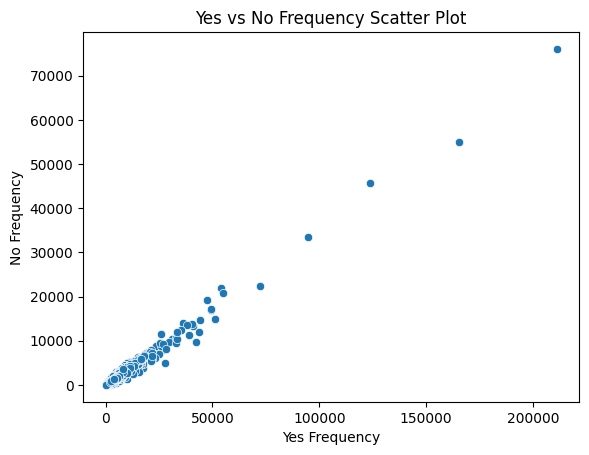

In [34]:
df = pd.DataFrame({
    'key': list(freq['yes'].keys() | freq['no'].keys()),  # Union of all keys
    'yes': [freq['yes'].get(k, 0) for k in freq['yes'].keys() | freq['no'].keys()],
    'no':  [freq['no'].get(k, 0) for k in freq['yes'].keys() | freq['no'].keys()]
})

# Scatter plot
sns.scatterplot(data=df, x='yes', y='no')
plt.xlabel('Yes Frequency')
plt.ylabel('No Frequency')
plt.title('Yes vs No Frequency Scatter Plot')
plt.legend([], [], frameon=False)  # Hide legend just in case
plt.show()

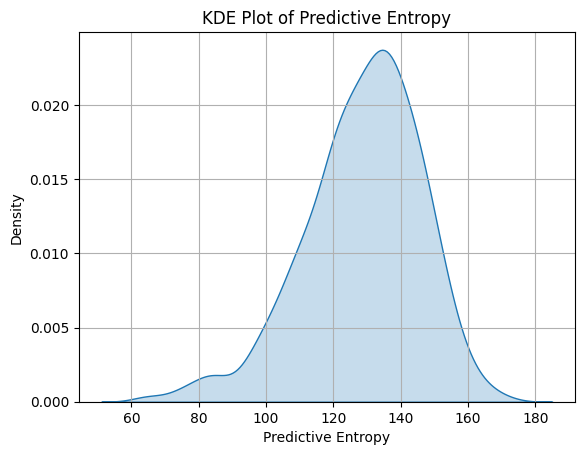

In [38]:
sns.kdeplot(data=comprehensive_dataframe, x='predictive_entropy', fill=True)

plt.title('KDE Plot of Predictive Entropy')
plt.xlabel('Predictive Entropy')
plt.ylabel('Density')
plt.grid(True)
plt.show()


In [39]:
comprehensive_dataframe['predictive_entropy'].mean()

128.58382

In [40]:
comprehensive_dataframe['is_high_entropy'] = comprehensive_dataframe['predictive_entropy'] > comprehensive_dataframe['predictive_entropy'].mean()

0       True
1      False
2      False
3       True
4      False
       ...  
812    False
813    False
814    False
815     True
816    False
Name: is_high_entropy, Length: 817, dtype: bool

In [45]:
freq_entropy = {
    'True': {},
    'False': {}
}

n_tokens = 0

for index, row in comprehensive_dataframe.iterrows():
    activation = activations.iloc[index]
    for i, gen in enumerate(['gen1', 'gen2', 'gen3', 'gen4', 'gen5']):
        for batch in activation[gen]:
            for token in batch:
                n_tokens += 1
                for sae_latent in token.keys():
                    label = 'True' if row['is_high_entropy'] else 'False'
                    if sae_latent not in freq_entropy[label]:
                        freq_entropy[label][sae_latent] = 0
                    freq_entropy[label][sae_latent] += 1

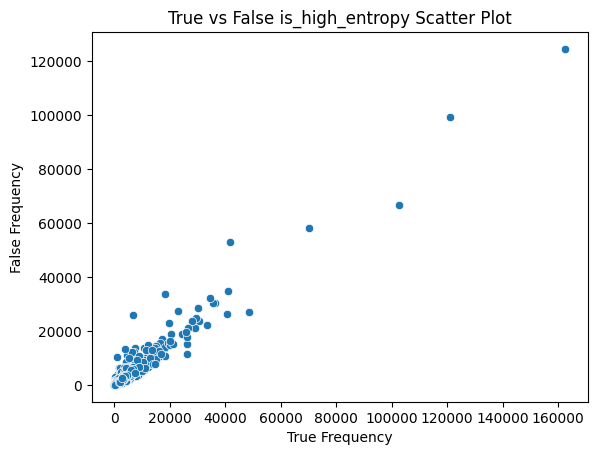

In [47]:
df = pd.DataFrame({
    'key': list(freq_entropy['True'].keys() | freq_entropy['False'].keys()),  # Union of all keys
    'True': [freq_entropy['True'].get(k, 0) for k in freq_entropy['True'].keys() | freq_entropy['False'].keys()],
    'False':  [freq_entropy['False'].get(k, 0) for k in freq_entropy['True'].keys() | freq_entropy['False'].keys()]
})

# Scatter plot
sns.scatterplot(data=df, x='True', y='False')
plt.xlabel('True Frequency')
plt.ylabel('False Frequency')
plt.title('True vs False is_high_entropy Scatter Plot')
plt.legend([], [], frameon=False)  # Hide legend just in case
plt.show()

In [62]:
high_no_low_yes = [
    (key, freq_entropy['False'].get(key, 0))
    for key in set(freq_entropy['True']) | set(freq_entropy['False'])
    if freq_entropy['False'].get(key, 0) > 20000 and freq_entropy['True'].get(key, 0) < 10000
]
high_no_low_yes.sort(key=lambda x: x[1], reverse=True)

# Optional: just the keys, sorted
high_no_low_yes_keys = [k for k, _ in high_no_low_yes]


In [63]:
high_no_low_yes_keys

['5651']

In [64]:
from IPython.display import IFrame
html_template = "https://neuronpedia.org/{}/{}/{}?embed=true&embedexplanation=true&embedplots=true&embedtest=true&height=300"

def get_dashboard_html(sae_release = "gemma-2-2b", sae_id="20-gemmascope-res-16k", feature_idx=0):
    return html_template.format(sae_release, sae_id, feature_idx)

html = get_dashboard_html(sae_release = "gemma-2-2b", sae_id="20-gemmascope-res-16k", feature_idx=5651)
IFrame(html, width=1200, height=600)
